<a href="https://colab.research.google.com/github/sfhbarnett/UNet/blob/master/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets set up the imports

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from scipy.ndimage import map_coordinates
from scipy import interpolate
from scipy.ndimage import label
plt.rcParams['figure.figsize'] = [22, 10]

Now lets create all the functions we need for the unet

In [9]:

### DataStore ### ===========================================

def generateField(image, subsamplevector, strength):
    shape = image.shape
    nvectors = shape[1]//subsamplevector
    nvectors = 3
    mu, sigma = 0, 0.1  # mean and standard deviation
    sx = np.random.normal(mu, sigma, (nvectors, nvectors))
    sy = np.random.normal(mu, sigma, (nvectors, nvectors))
    x = np.linspace(1, shape[1], nvectors)
    y = np.linspace(1, shape[2], nvectors)
    f = interpolate.interp2d(x, y, sx)
    xnew = np.linspace(1, shape[1], shape[1])
    ynew = np.linspace(1, shape[2], shape[2])
    sxnew = f(xnew, ynew)
    f = interpolate.interp2d(x, y, sy)
    synew = f(xnew, ynew)
    # plt.quiver(xnew, ynew, sxnew, synew,scale=10)
    # plt.show()
    return sxnew, synew


def elasticdeform(image, field):
    rows, cols = image.shape[1], image.shape[2]
    sx, sy = field
    src_cols = np.linspace(1, cols, cols)
    src_rows = np.linspace(1, rows, rows)
    src_rows, src_cols = np.meshgrid(src_rows, src_cols)
    out_coord = [src_rows+sx*100, src_cols+sy*100] # scale vectors by a factor of 100
    #convert tensor to numpy and perform elastic deformations
    out_img = torch.from_numpy(map_coordinates(image.numpy().squeeze(), out_coord, mode='nearest')).unsqueeze(0)
    return out_img


def generateWeights(img):
    """
    Generates the weights to improve instance segmentation for closely positioned objects of the same class
    :param img: The PIL mask to generate the weights from,
    :return: numpy array of the weights
    """
    img = np.asarray(img)
    weights = np.zeros(img.shape)
    # Make 4-connected structure
    structure = np.ones((3, 3), dtype=int)
    structure[0, 0] = 0
    structure[0, -1] = 0
    structure[-1, 0] = 0
    structure[-1, -1] = 0

    # Padding to deal with boreder region
    padamount = 10
    img = np.pad(img, padamount, mode='constant', constant_values=0)

    # find connected components
    labeled, ncomponents = label(img // 255, structure)

    sigma = 2 * 6 ** 2
    radius = 10

    # Loop over each pixel
    for x in range(padamount, img.shape[0] - padamount):
        for y in range(padamount, img.shape[1] - padamount):
            if img[x, y] == 0:
                distance = []
                crop = labeled[x - radius:x + radius + 1, y - radius:y + radius + 1]  # Crop out region to test
                objects = np.unique(crop)  # find unique objects
                for obj in objects[1:]:  # find closed point in each object to central/test pixel
                    coords = np.where(crop == obj)
                    d = [(coords[0][x] - radius + 1) ** 2 + (coords[1][x] - radius + 1) ** 2 for x in
                         range(len(coords[0]))]
                    distance.append(min(d))
                if len(distance) > 1:
                    distance.sort() # get closest two points and calculate weight
                    weights[x - padamount, y - padamount] = np.exp(
                        -(np.sqrt(distance[0]) + np.sqrt(distance[1])) ** 2 / sigma)
    return weights


def transform(image, mask, weights):

    # Elastic deformations
    sx, sy = generateField(image, 50, 1)
    image = elasticdeform(image, (sx, sy))
    mask = elasticdeform(mask, (sx, sy))
    mask = mask.numpy().squeeze()
    mask[mask <= 0.5] = 0
    mask[mask > 0.5] = 1
    mask = torch.from_numpy(mask).unsqueeze(0)
    weights = elasticdeform(weights, (sx, sy))

    # i, j, h, w = transforms.RandomCrop.get_params(
    #     image, output_size=(1024, 1024))
    # image = transforms.functional.crop(image, i, j, h, w)
    # mask = transforms.functional.crop(mask, i, j, h, w)
    # weights = transforms.functional.crop(weights, i, j, h, w)

    # Random horizontal flipping
    if random.random() > 0.5:
        image = transforms.functional.hflip(image)
        mask = transforms.functional.hflip(mask)
        weights = transforms.functional.hflip(weights)

    # Random vertical flipping
    if random.random() > 0.5:
        image = transforms.functional.vflip(image)
        mask = transforms.functional.vflip(mask)
        weights = transforms.functional.hflip(weights)
    return image, mask, weights


class Datastore(Dataset):
    def __init__(self, filelist, masklist, weightlist, root_dir, transforms=None):
        self.images = filelist
        self.masks = masklist
        self.weights = weightlist
        self.root_dir = root_dir
        self.trainimagepath = os.path.join(self.root_dir, 'image')
        self.trainmaskpath = os.path.join(self.root_dir, 'label')
        self.trainweightpath = os.path.join(self.root_dir, 'weights')
        self.transform = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.trainimagepath, self.images[idx])
        mask_name = os.path.join(self.trainmaskpath, self.images[idx])
        if self.weights != None:
            weight_name = os.path.join(self.trainweightpath, self.weights[idx])
        outname = self.images[idx]
        if self.transform is not None:
            #self.transform(Image.open(img_name))
            im = np.array(Image.open(img_name))
            im = im.astype(np.float32)
            image = self.transform(torch.from_numpy(im).unsqueeze(0))
            masktransform = transforms.Compose([transforms.ToTensor()])
            mask = Image.open(mask_name)
            mask = masktransform(mask)
            maskmean = 0
            while maskmean < 0.2:
                i, j, h, w = transforms.RandomCrop.get_params(
                    mask, output_size=(512, 512))
                testmask = TF.crop(mask,i,j,h,w)
                maskmean = torch.mean(testmask)
            weights = Image.open(weight_name)
            weights = masktransform(weights)+1*20
            image = TF.crop(image,i,j,h,w)
            mask = TF.crop(mask,i,j,h,w)
            weights = TF.crop(weights,i,j,h,w)
            # Flip image and elastic deform
            image, mask, weights = transform(image, mask, weights)
            sample = {'image': image, 'mask': mask, 'weights': weights,'name':outname}
        else:
            image = Image.open(img_name)
            mask = Image.open(mask_name)
            sample = {'image': image, 'mask': mask}
        return sample

### Nueral Network ### ===========================================

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inconv1 = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inconv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


class down(nn.Module):
    def __init__(self, inchannels, outchannels):
        super(down, self).__init__()
        self.level = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(inchannels, outchannels, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannels, outchannels, kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True),
        )

    def forward(self,x):
        x = self.level(x)
        return x


class inconv(nn.Module):
    def __init__(self, inchannels, outchannels):
        super(inconv, self).__init__()
        self.step = nn.Sequential(
            nn.Conv2d(inchannels, outchannels, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannels, outchannels, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.step(x)
        return x


class Up(nn.Module):
    def __init__(self, inchannels, outchannels):
        super(Up, self).__init__()
        #self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up = nn.ConvTranspose2d(inchannels, inchannels//2, stride=2, kernel_size=2)
        self.conv = nn.Sequential(
            nn.Conv2d(inchannels, outchannels, kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannels, outchannels, kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(outchannels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, inchannels, outchannels):
        super(outconv, self).__init__()
        self.step = nn.Conv2d(inchannels, outchannels, kernel_size=1)

    def forward(self, x):
        x = self.step(x)
        return x


### TRAIN PREDICT ### ===========================================

def train(net, optimizer, trainloader, startepoch, epochs, gpu, batch_N, N_train, mainpath, scheduler, valloader):
    dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(dev)
    net.to(dev)
    writer = SummaryWriter()
    counter = 0
    tforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
    for epoch in range(startepoch, epochs):
        epoch_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            inputs = data['image']
            inputs = inputs.permute(0, 1, 2, 3)
            masks = data['mask']
            weights = data['weights']
            inputs = inputs.to(dev)
            masks = masks.to(dev)
            weights = weights.to(dev)
            optimizer.zero_grad()
            if gpu:
                inputs = inputs.to(gpu)
                masks = masks.to(gpu)
            print(f'Is tensor on GPU: {inputs.is_cuda}')
            predicted_masks = net(inputs)

            if gpu == 0:
                display.clear_output(wait=True)
                plt.subplot(1, 4, 1)
                plt.title("Input")
                im = plt.imshow(inputs[0].cpu().permute(1, 2, 0).detach().numpy().squeeze(),cmap='gray')
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
                plt.subplot(1, 4, 2)
                plt.title("Mask")
                im = plt.imshow(masks[0].cpu().detach().numpy().squeeze())
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
                plt.subplot(1, 4, 3)
                plt.title("Prediction")
                p = predicted_masks[0].cpu().detach().numpy().squeeze()
                im = plt.imshow(p)
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
                plt.subplot(1, 4, 4)
                plt.title("Prediction scaled")
                p[p>0] = 1
                p[p<0] = 0
                im = plt.imshow(p)
                plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
                plt.tight_layout()
                plt.show()
                plt.draw()
                plt.pause(0.0001)

            #criterion = nn.BCEWithLogitsLoss(weight=weights.view(-1))
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(predicted_masks.view(-1), masks.contiguous().view(-1))
            epoch_loss += loss.item()

            print(f'Epoch: {epoch} --- LR: {optimizer.param_groups[0]["lr"]} --- progress: {round(i*batch_N/N_train,4)} --- loss: {round(loss.item(),4)}')

            loss.backward()
            optimizer.step()

        print('Training finished ! Mean loss: {}'.format(epoch_loss / (i+1)))
        writer.add_scalar("Loss/train", epoch_loss/(i+1), epoch)
        net.eval()
        validationloss = 0
        for i, data in enumerate(valloader, 0):
            inputs = data['image']
            inputs = inputs.to(dev)
            inputs = inputs.permute(0, 1, 2, 3)
            masks = data['mask']
            masks = masks.to(dev)
            weights = data['weights']
            weights = weights.to(dev)
            predicted_masks = net(inputs)
            #criterion = nn.BCEWithLogitsLoss(weight=weights.view(-1))
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(predicted_masks.view(-1), masks.contiguous().view(-1))
            validationloss += loss.item()
        print(f'Validation finished, mean loss {validationloss/(i+1)}')

        scheduler.step(validationloss)

        modelsavepath = os.path.join(mainpath,'model_blog.pt')

        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
        }, modelsavepath)

        print(f'Model saved at {modelsavepath}')

def predict(net, mainpath):
    filelist = os.listdir(mainpath)
    net.eval()
    for filename in filelist[1:]:
        print(filename)
        img = np.array(Image.open(os.path.join(mainpath, filename)))
        tforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
        img = tforms(img)
        img = img.unsqueeze(0)

        with torch.no_grad():
            prediction = net(img)
            # plt.imshow(prediction[0].detach().numpy().squeeze())
            # plt.show()
            predicted = prediction[0].detach().numpy().squeeze()
            predicted[predicted <= 0] = 0
            predicted = Image.fromarray(predicted)
            predicted.save(os.path.join(mainpath, filename[:-4]+'_predicted.tif'))

def main(mainpath, load=False, training=True, weights=False, rgb=0):

    torch.cuda.device(0)
    plt.ion()

    # If data is multi or single channel
    if rgb:
        tforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        net = UNet(n_channels=3, n_classes=1)
    else:
        tforms = transforms.Compose([transforms.Normalize(0.5, 0.5)])
        net = UNet(n_channels=1, n_classes=1)

    if training:
        trainpath = os.path.join(mainpath, 'image')
        filelist = os.listdir(trainpath)
        if ".DS_Store" in filelist:
            filelist.remove(".DS_Store")
        trainmasks = os.path.join(mainpath, 'label')
        masklist = os.listdir(trainmasks)
        print(filelist)
        if weights:
            if os.path.isdir(os.path.join(mainpath, 'weights')) != 1:
                os.mkdir(os.path.join(mainpath, 'weights'))
                print("generating weights")
                for file in masklist:
                    img = Image.open(os.path.join(mainpath, 'label', file))
                    weights = generateWeights(img)
                    weights = Image.fromarray(weights)
                    weights.save(os.path.join(mainpath, 'weights', file[:-4]+'.tif'))
                print("generated weights")
                weightspath = os.path.join(mainpath, 'weights')
                weightslist = os.listdir(weightspath)
            else:
                weightspath = os.path.join(mainpath,'weights')
                weightslist = os.listdir(weightspath)
        else:
            weightslist = []

        dataset = Datastore(filelist, masklist, weightslist, mainpath, transforms=tforms)
        train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)*0.3)])
        batch_N = 1
        trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_N, shuffle=True, num_workers=0)
        valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_N, shuffle=True,
                                                  num_workers=0)
        N_train = len(dataset)
        gpu = 0
        startepoch = 0

        if gpu == 1:
            gpu = torch.device("cuda:0")
            print("Connected to device: ", gpu)
            net = net.to(gpu)

        epochs = 400
        lr = 0.0001
        val_percent = 0.05
        optimizer = optim.SGD(net.parameters(),
                              lr=lr,
                              momentum=0.9,
                              weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5,
                                                               min_lr=0.00000001, verbose=True)

        criterion = nn.BCEWithLogitsLoss()
        fig = plt.figure(figsize=(18, 5), dpi=80, facecolor='w', edgecolor='k')
        fig.tight_layout()

        # Load in previous model
        if load:
            try:
                checkpoint = torch.load(os.path.join(mainpath,'model_blog.pt'))
                net.cuda()
                net.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                startepoch = checkpoint['epoch'] + 1
                loss = checkpoint['loss']
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            except FileNotFoundError:
                print(f"No model file found at {mainpath}")

        train(net, optimizer, trainloader, startepoch, epochs, gpu, batch_N, N_train, mainpath,scheduler, valloader)
    else:
        checkpoint = torch.load('model_guv.pt')
        net.load_state_dict(checkpoint['model_state_dict'])
        predict(net, mainpath)


Now lets perform training

Load=True indicates loading a partially trained model

training=True indicates whether we are training or prediction

weights=True tells the computer whether to generate weights to aid instance segmentation:

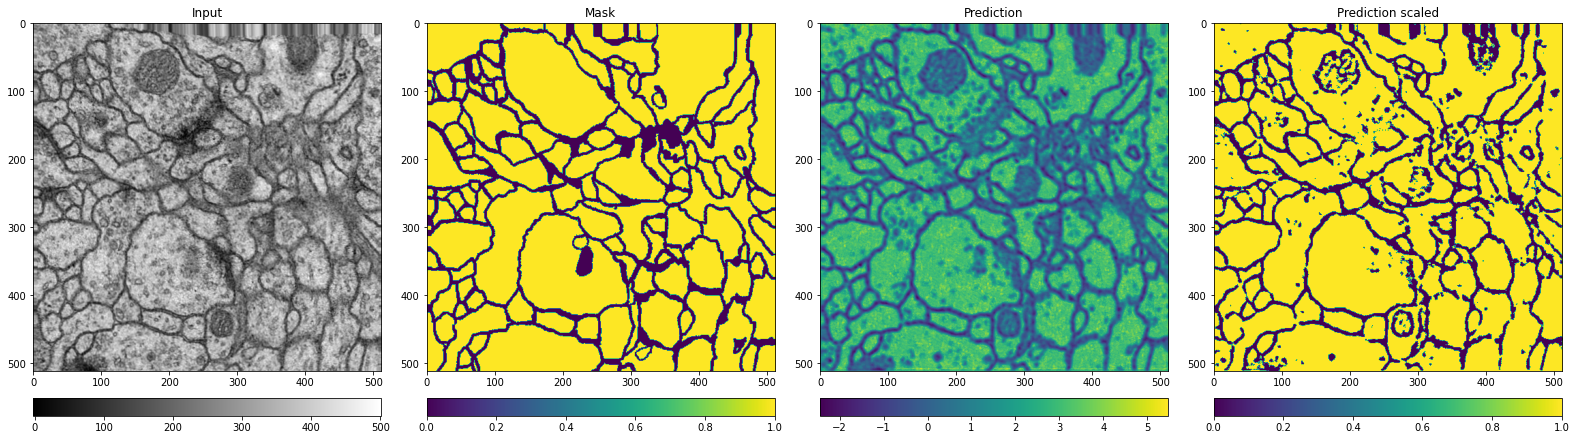

<Figure size 1584x720 with 0 Axes>

Epoch: 399 --- LR: 1.0000000000000004e-08 --- progress: 0.6667 --- loss: 0.3012
Training finished ! Mean loss: 0.31004902436619713
Validation finished, mean loss 0.3415074381563399
Model saved at /content/drive/MyDrive/membrane/train/model_blog.pt


In [10]:
    rootpath = '/content/drive/MyDrive/membrane/train'
    main(rootpath, load=True, training=True, weights=True)